In [17]:
import geopandas as gpd
import numpy as np
from deap import base, creator, tools, algorithms
import random
from shapely.geometry import Point

# Загрузка данных
districts = gpd.read_file('area_borders.geojson')  # Полигоны районов
clinics = gpd.read_file('amenity_hospital.geojson')     # Точки поликлиник

# Определение границ области
min_x, min_y, max_x, max_y = districts.total_bounds

# Параметры генетического алгоритма
POPULATION_SIZE = 100
GENERATIONS = 50
CXPB, MUTPB = 0.5, 0.2

# Создание типов для генетического алгоритма
creator.create("FitnessMin", base.Fitness, weights=(-1.0,))
creator.create("Individual", list, fitness=creator.FitnessMin)

toolbox = base.Toolbox()
toolbox.register("attr_float_longitude", random.uniform, min_x, max_x)  # Долгота
toolbox.register("attr_float_latitude", random.uniform, min_y, max_y)   # Широта

# Создание индивидов (пары координат для поликлиник)
num_clinics = 5  # Количество поликлиник
toolbox.register("individual", tools.initCycle, creator.Individual,
                (toolbox.attr_float_longitude, toolbox.attr_float_latitude),
                n=num_clinics)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

# Определение целевой функции
def evaluate(individual):
    # Преобразуем особь в координаты поликлиник
    clinic_locations = [(individual[i], individual[i+1]) for i in range(0, len(individual), 2)]
    
    # Вычисляем среднее расстояние, взвешенное по спросу
    total_distance = 0
    total_demand = 0
    
    for idx, district in districts.iterrows():
        district_center = district.geometry.centroid
        min_dist = min([district_center.distance(Point(clinic)) for clinic in clinic_locations])
        total_distance += min_dist * district['demand']  # Используем спрос (demand)
        total_demand += district['demand']
    
    average_distance = total_distance / total_demand
    return average_distance,

toolbox.register("evaluate", evaluate)
toolbox.register("mate", tools.cxTwoPoint)
toolbox.register("mutate", tools.mutGaussian, mu=0, sigma=1, indpb=0.1)
toolbox.register("select", tools.selTournament, tournsize=3)

# Запуск генетического алгоритма
population = toolbox.population(n=POPULATION_SIZE)
algorithms.eaSimple(population, toolbox, cxpb=CXPB, mutpb=MUTPB, ngen=GENERATIONS, verbose=True)

# Вывод лучшего решения
best_individual = tools.selBest(population, k=1)[0]
print("Best individual is: %s\nwith fitness: %s" % (best_individual, best_individual.fitness.values))

/opt/anaconda3/lib/python3.12/site-packages/deap/creator.py:185: RuntimeWarning: A class named 'FitnessMin' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/opt/anaconda3/lib/python3.12/site-packages/deap/creator.py:185: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "


gen	nevals
0  	100   
1  	61    
2  	67    
3  	64    
4  	64    
5  	64    
6  	65    
7  	51    
8  	58    
9  	63    
10 	68    
11 	54    
12 	60    
13 	58    
14 	54    
15 	59    
16 	61    
17 	57    
18 	62    
19 	56    
20 	53    
21 	57    
22 	60    
23 	61    
24 	62    
25 	65    
26 	68    
27 	72    
28 	54    
29 	62    
30 	52    
31 	63    
32 	50    
33 	53    
34 	45    
35 	63    
36 	65    
37 	64    
38 	62    
39 	62    
40 	79    
41 	59    
42 	59    
43 	57    
44 	55    
45 	61    
46 	56    
47 	62    
48 	61    
49 	61    
50 	48    
Best individual is: [35.903204039134636, 56.87012751914416, 35.814019026887166, 56.84154510418351, 35.95675245829594, 56.812667105118884, 35.89673477313661, 56.865035275294964, 35.75264641990964, 56.97951222234786]
with fitness: (0.007284343831781906,)


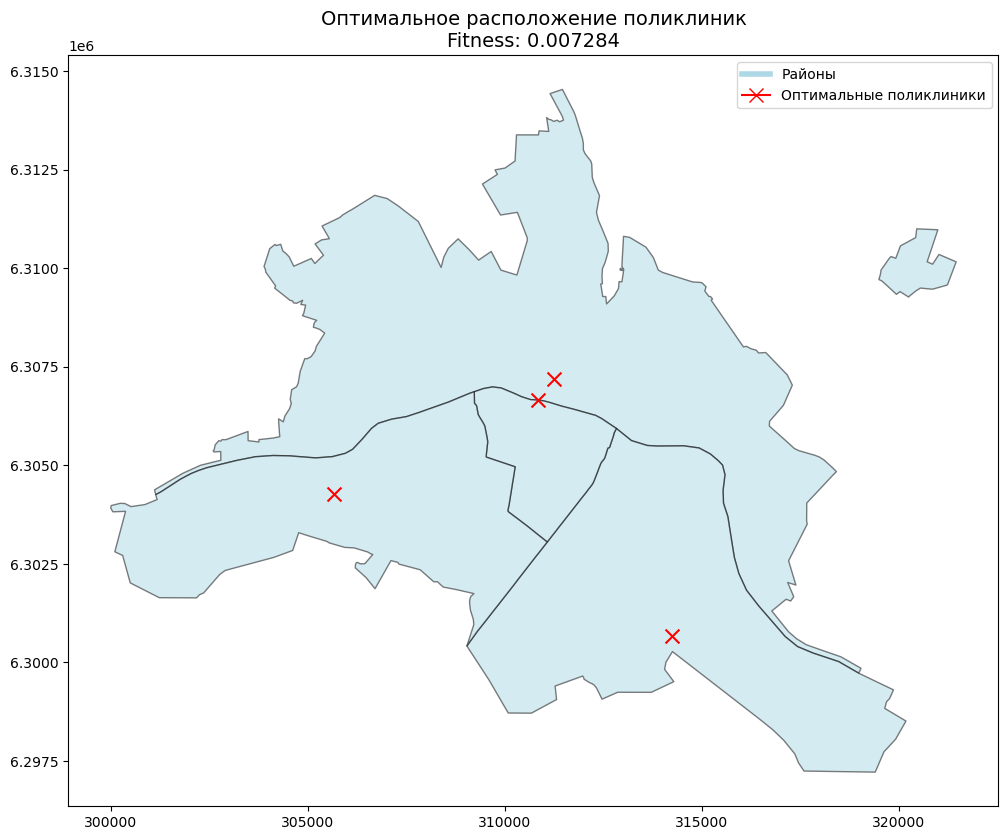

In [26]:
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import Point

# Загрузка данных (полигоны районов)
districts = gpd.read_file('area_borders.geojson')  # Замените на путь к вашему файлу

# Проверка и преобразование проекции
districts.set_crs(epsg=4326, inplace=True)  # Устанавливаем проекцию WGS84, если не задана
districts_utm = districts.to_crs(epsg=32637)  # Преобразуем в UTM для визуализации

# Получаем границы области
min_x, min_y, max_x, max_y = districts.total_bounds

# Координаты найденных поликлиник (лучшее решение)
best_individual = [35.903204039134636, 56.87012751914416, 
                   35.814019026887166, 56.84154510418351, 
                   35.95675245829594, 56.812667105118884, 
                   35.89673477313661, 56.865035275294964, 
                   35.75264641990964, 56.97951222234786]

# Преобразуем координаты поликлиник в GeoDataFrame
clinic_locations = [(best_individual[i], best_individual[i+1]) for i in range(0, len(best_individual), 2)]
clinics_gdf = gpd.GeoDataFrame(geometry=gpd.points_from_xy(
    [x for x, y in clinic_locations],  # Долгота
    [y for x, y in clinic_locations]   # Широта
), crs='EPSG:4326')  # Указываем, что координаты в WGS84

# Фильтруем точки, чтобы они находились в пределах области
clinics_gdf = clinics_gdf.cx[min_x:max_x, min_y:max_y]

# Визуализация
fig, ax = plt.subplots(figsize=(12, 10))

# Отображаем полигоны районов
districts_utm.plot(ax=ax, color='lightblue', edgecolor='black', alpha=0.5, label='Районы')

# Отображаем найденные поликлиники
clinics_gdf_utm = clinics_gdf.to_crs(epsg=32637)
clinics_gdf_utm.plot(ax=ax, color='red', marker='x', markersize=100, label='Оптимальные поликлиники')

# Добавляем легенду
from matplotlib.lines import Line2D
legend_elements = [
    Line2D([0], [0], color='lightblue', lw=4, label='Районы'),
    Line2D([0], [0], marker='x', color='red', markerfacecolor='red', markersize=10, label='Оптимальные поликлиники')
]
ax.legend(handles=legend_elements, loc='upper right')

# Добавляем заголовок и значение целевой функции
ax.set_title(f'Оптимальное расположение поликлиник\nFitness: {0.007284343831781906:.6f}', fontsize=14)

# Показать карту
plt.show()

In [22]:
# Преобразуем координаты поликлиник в ту же проекцию, что и районы
clinics_gdf_utm = clinics_gdf.to_crs(epsg=32637)